In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns
from scipy import stats
import os
import re
import pickle
import imutils
from scipy.signal import find_peaks, savgol_filter
from pathlib import Path

In [2]:
def round_up(number):
    if number >= 0:
        return np.ceil(number * 10) / 10
    else:
        return np.floor(number * 10) / 10

def round_down(number):
    if number >= 0:
        return np.floor(number * 10) / 10
    else:
        return np.ceil(number * 10) / 10

In [3]:
def init_condition(avis):
    capture = cv.VideoCapture(avis)
    _, frame1 = capture.read()
    num_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    # Create mask
    hsv = np.zeros_like(frame1)
    # Make image saturation to a maximum value
    hsv[..., 1] = 255
    return capture, num_frames,hsv

In [4]:
main_dir = "D://testing_data//F6//cropped//"
files = os.listdir(main_dir)
avis = [file for file in files if re.search(".avi",os.path.splitext(file)[1])]
avis

['F6-set001-b-sweep-200-fps_cropped.avi',
 'F6-set002-r-spiral-200-fps_cropped.avi',
 'F6-set003-l-spiral-200-fps_cropped.avi',
 'F6-set004-b-spiral-200-fps_cropped.avi']

In [5]:
avi = main_dir + avis[0]
capture, num_frames, hsv = init_condition(avi)

## calcuate mean absolute difference(mseval1) and mean squared erro(mseval)

In [6]:
from tqdm import tqdm

mag1 = []
ang1 = []
strike_frame = []
mag_final = []
arg_final = []
mseval=[]
mseval1 = []

for i in tqdm(range(1, num_frames)):
    if i < (num_frames) - 1 :
        pre = capture.set(1, i-1)
        _,pre = capture.read()
        pre_final = cv.cvtColor(pre, cv.COLOR_BGR2GRAY)
        
        cur = capture.set(1, i)
        _,cur=capture.read()
        cur_final = cv.cvtColor(cur, cv.COLOR_BGR2GRAY)
        
        h, w = cur_final.shape
        diff = cv.subtract(cur_final, pre_final)
        
        err1 = np.mean(diff) / (float(h * w))  # average absolute difference per pixel  (/ h*w is a typo?)
        # err1 = np.mean(diff)
        mseval1.append(err1)
        
        err = np.sum((cur_final.astype("float") - pre_final.astype("float")) ** 2)        #Sum of Squared Differences
        mse = err / (float(h * w))     # Mean Squared Error
        mseval.append(mse)


100%|████████████████████████████████████████████████████████████████████████| 155998/155998 [01:55<00:00, 1351.58it/s]


### parameters

In [7]:
# import numpy as np
# from scipy.stats import gaussian_kde
# from scipy.signal import argrelmin

# # Compute KDE
# kde = gaussian_kde(mseval)
# x = np.linspace(np.min(mseval), np.max(mseval), 1000)  # Grid points
# y = kde(x)  # Density values

# from scipy.signal import find_peaks

# # Find peaks in the KDE
# peaks, _ = find_peaks(y)  # Adjust `prominence` as needed
# peak1, peak2 = x[peaks[0]], x[peaks[1]]  # Two largest peaks

# # Get the values between the two peaks and find the minimum
# valid_indices = [i for i in range(x.shape[0]) if i > peaks[0] and i < peaks[1]]
# minimum = x[valid_indices[np.argmin(y[valid_indices])]]

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(4,3))
# sns.kdeplot(mseval, shade=True,color='crimson', label='KDE')

# # Plot peaks
# plt.scatter([peak1, peak2], kde([peak1, peak2]), color='blue', s=50, label='Peaks')

# # Plot inflection point
# plt.axvline(minimum, color='black', linestyle='--', 
#             label='Inflection')
# plt.xlim(0, 12)
# plt.title(f"Mean Squared Error")
# plt.legend()
# plt.show()

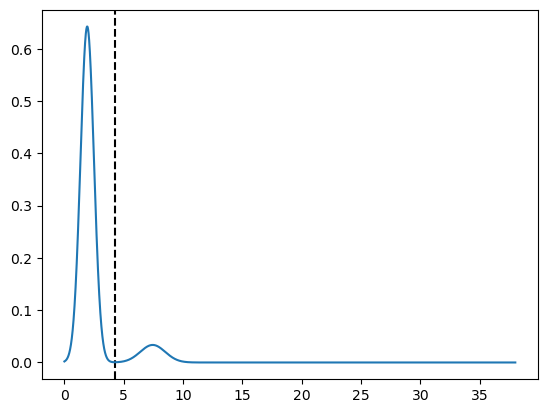

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2)
mseval = np.array(mseval)
gmm.fit(mseval.reshape(-1, 1))

x = np.linspace(0, np.ceil(np.max(mseval)), 10000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

#### peak
peaks, _ = find_peaks(y)  # Adjust `prominence` as needed
peak1, peak2 = x[peaks[0]], x[peaks[1]]  # Two largest peaks

# Get the values between the two peaks and find the minimum
valid_indices = [i for i in range(x.shape[0]) if i > peaks[0] and i < peaks[1]]
minimum = x[valid_indices[np.argmin(y[valid_indices])]]

plt.axvline(minimum, color='black', linestyle='--', 
            label='Inflection')
plt.plot(x, y)

In [9]:
mse_threshold = minimum
res = []
for a in range(len(mseval)):
        if mseval[a] > mse_threshold:
            res.append(a)

In [10]:
def load_significant_frames(video_path, significant_indices):
    """Load frames that exceeded the MSE threshold"""
    cap = cv.VideoCapture(video_path)
    significant_frames = []
    
    for idx in tqdm(range(int(cap.get(cv.CAP_PROP_FRAME_COUNT)))):
        ret, frame = cap.read()
        if not ret:
            break
        if idx in significant_indices:
            significant_frames.append(frame)
    
    cap.release()
    return significant_frames

In [11]:
len(res)

13701

# Optical Flow Analysis
   

In [12]:
frames = load_significant_frames(avi, res)
vertical_motion = []
prev_gray = cv.cvtColor(frames[0], cv.COLOR_BGR2GRAY)

for frame in tqdm(frames[1:], desc="Analyzing Motion"):
    curr_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
   
    flow = cv.calcOpticalFlowFarneback(
        prev_gray, curr_gray, 
        None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    
    
    vertical_flow = flow[..., 1]
    avg_vertical = np.mean(vertical_flow)
    vertical_motion.append(avg_vertical)
    
    prev_gray = curr_gray

Analyzing Motion: 100%|████████████████████████████████████████████████████████| 13700/13700 [00:05<00:00, 2652.81it/s]


In [13]:
# Smooth the data
vertical_motion = np.array(vertical_motion)
smoothed = savgol_filter(vertical_motion, window_length=11, polyorder=3)

C:\Users\richa\AppData\Local\Temp\ipykernel_15004\834370704.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(smoothed, shade=True,color='crimson', label='KDE')


Text(0.5, 1.0, 'distribution for y shift')

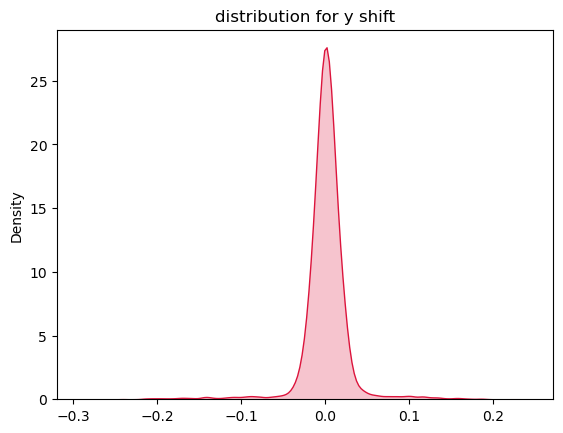

In [14]:
sns.kdeplot(smoothed, shade=True,color='crimson', label='KDE')
plt.title("distribution for y shift")
# plt.savefig(f"distribution.png", transparent=None,facecolor='white')

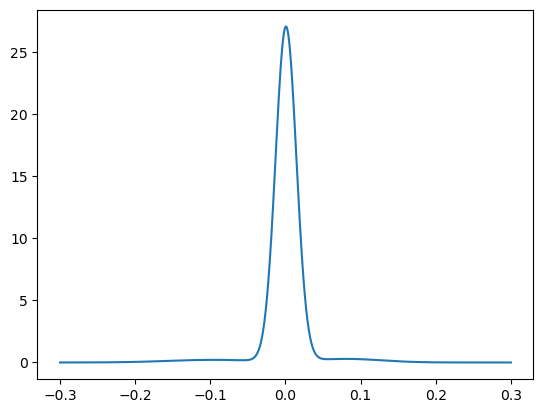

In [15]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 3)

gmm.fit(smoothed.reshape(-1, 1))

x = np.linspace(round_up(np.min(smoothed)), round_up(np.max(smoothed)), 10000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

plt.plot(x, y)

In [246]:
from scipy.stats import ttest_ind
from scipy.signal import find_peaks, savgol_filter

def detect_significant_motion(smoothed_signal, noise_window=10, alpha=0.01, 
                             min_duration=3, prominence_factor=2.0):
    """
    Robust motion detection using:
    1. Noise floor estimation
    2. Statistical significance testing
    3. Temporal consistency checks
    """
    # 1. Estimate noise characteristics using rolling baseline
    noise_estimates = []
    for i in range(len(smoothed_signal)):
        start = max(0, i - noise_window)
        end = min(len(smoothed_signal), i + noise_window)
        noise_estimates.append(np.std(smoothed_signal[start:end]))
    
    noise_std = np.median(noise_estimates)  # Robust noise estimate
    
    # 2. Adaptive threshold based on noise floor
    upward_thresh = -prominence_factor * noise_std
    downward_thresh = prominence_factor * noise_std
    
    # # 3. Find candidate peaks with prominence requirements
    # upward_candidates, _ = find_peaks(-smoothed_signal, threshold=-upward_thresh
    #                                  # prominence=abs(upward_thresh)
    #                                  )
                                    
    # downward_candidates, _ = find_peaks(smoothed_signal, threshold=downward_thresh
    #                                    # prominence=abs(downward_thresh)
    #                                    )
    # valid_up = upward_candidates
    # valid_down = downward_candidates

    valid_up = []
    valid_down = []
    for i, signal in enumerate(smoothed_signal):
        if signal < upward_thresh:
            valid_up.append(i)
        if signal > downward_thresh:
            valid_down.append(i)
    # # 4. Statistical validation of peaks
    # valid_up = []
    # for peak in upward_candidates:
    #     # Compare peak region to baseline
    #     peak_vals = smoothed_signal[max(0,peak-2):peak+3]
    #     _, pval = ttest_ind(peak_vals, smoothed_signal, equal_var=False)
    #     # if pval < alpha and np.mean(peak_vals) < upward_thresh:
    #     #     valid_up.append(peak)
    #     if np.mean(peak_vals) < upward_thresh:
    #         valid_up.append(peak)
    
    # valid_down = []
    # for peak in downward_candidates:
    #     peak_vals = smoothed_signal[max(0,peak-2):peak+3]
    #     _, pval = ttest_ind(peak_vals, smoothed_signal, equal_var=False)
    #     # if pval < alpha and np.mean(peak_vals) > downward_thresh:
    #     #     valid_down.append(peak)
    #     if np.mean(peak_vals) > downward_thresh:
    #         valid_down.append(peak)
    
    # 5. Temporal pairing with duration check
    cycles = []
    for up in valid_up:
        # Find next downward peak within reasonable window
        candidates = [d for d in valid_down if up < d <= up+30]
        if candidates:
            best_down = min(candidates, key=lambda x: abs(x-up))
            cycles.append((up, best_down))
    
    return cycles, valid_up, valid_down, noise_std

In [265]:
prominence_factor = 6
cycles, up_peaks, down_peaks, noise_level = detect_significant_motion(
    vertical_motion,
    noise_window=15,       # Larger for stable baselines
    # alpha=0.2,           # Stricter p-value threshold
    prominence_factor=prominence_factor  # Higher = fewer false positives
)

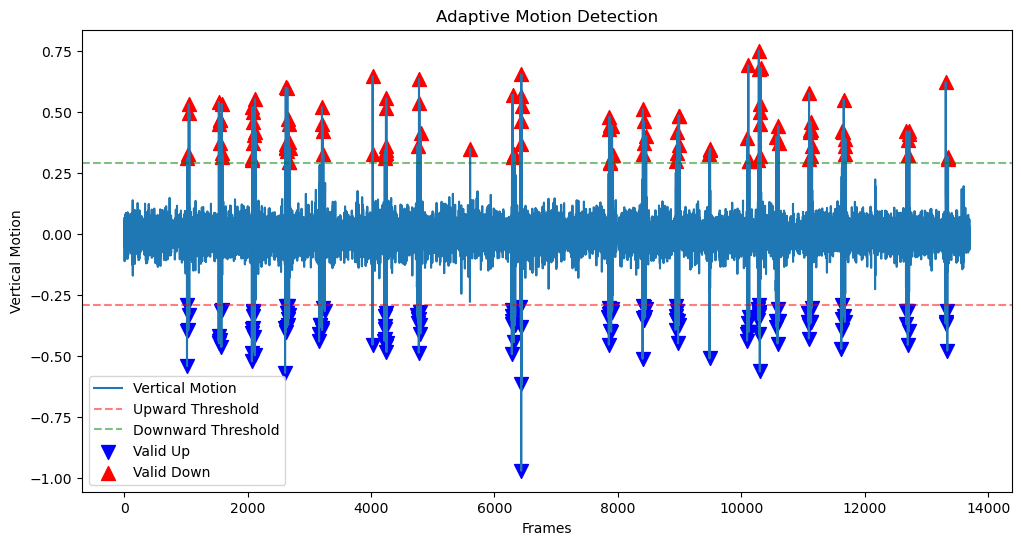

In [266]:
def plot_results(smoothed, cycles, up_peaks, down_peaks, noise_std):
    plt.figure(figsize=(12,6))
    plt.plot(vertical_motion, label='Vertical Motion')
    
    # Plot thresholds
    plt.axhline(-prominence_factor*noise_std, c='r', ls='--', alpha=0.5, label='Upward Threshold')
    plt.axhline(prominence_factor*noise_std, c='g', ls='--', alpha=0.5, label='Downward Threshold')
    
    # Plot peaks
    plt.scatter(up_peaks, vertical_motion[up_peaks], c='blue', marker='v', s=100, label='Valid Up')
    plt.scatter(down_peaks, vertical_motion[down_peaks], c='red', marker='^', s=100, label='Valid Down')
    
    # Highlight cycles
    # for (start, end) in cycles:
    #     plt.axvspan(start, end, alpha=0.1, color='purple')
    #     plt.text((start+end)/2, np.max(smoothed)*0.9, 
    #             f'{end-start}f', ha='center', color='purple')
    
    plt.title(f"Adaptive Motion Detection")
    plt.xlabel("Frames")
    plt.ylabel("Vertical Motion")
    plt.legend()
    # plt.xlim(4700, 4900)

plot_results(smoothed, cycles, up_peaks, down_peaks, noise_level)

In [267]:
motion = np.array([0] * num_frames, dtype=float) 


for i, frame in enumerate(res[1:]):
    motion[frame] = float(vertical_motion[i])

ori_up_peaks = []
ori_down_peaks = []

for frame in up_peaks:
    ori_up_peaks.append(res[frame])
    
for frame in down_peaks:
    ori_down_peaks.append(res[frame])

In [ ]:
res

In [293]:
ori_up_peak

[12216,
 12217,
 12229,
 12337,
 12450,
 18138,
 18151,
 18167,
 18206,
 18243,
 18368,
 18384,
 24128,
 24129,
 24140,
 24154,
 24155,
 24195,
 24196,
 24219,
 24245,
 24391,
 30094,
 30104,
 30116,
 30181,
 30223,
 30244,
 30298,
 30342,
 30360,
 30395,
 36088,
 36089,
 36115,
 36135,
 36343,
 36357,
 36417,
 36654,
 45850,
 48137,
 48151,
 48152,
 48169,
 48170,
 48190,
 48209,
 48226,
 48262,
 54172,
 54186,
 54235,
 54259,
 54282,
 54386,
 54387,
 54402,
 72106,
 72126,
 72127,
 72139,
 72140,
 72350,
 72366,
 72387,
 72406,
 73282,
 73289,
 73294,
 73298,
 90133,
 90147,
 90162,
 90163,
 90180,
 90181,
 90225,
 90362,
 90377,
 90396,
 96144,
 96145,
 96161,
 96177,
 96197,
 96376,
 96389,
 102103,
 102104,
 102115,
 102128,
 102165,
 102293,
 102306,
 102320,
 108140,
 115345,
 115346,
 115470,
 115471,
 115519,
 115520,
 115546,
 117198,
 117200,
 117207,
 117208,
 117215,
 117218,
 117221,
 117227,
 120183,
 120184,
 120368,
 120382,
 120404,
 126158,
 126159,
 126176,
 126224,

In [294]:
vertical_motion.shape

(13700,)

In [295]:
len(res)

13701

(72100.0, 72200.0)

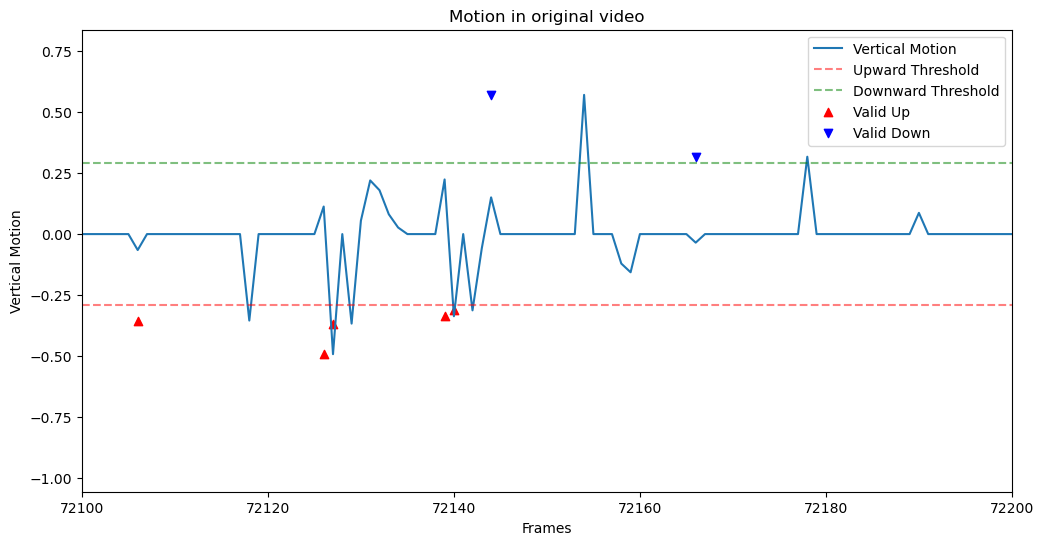

In [292]:
plt.figure(figsize=(12,6))
plt.plot(motion, label='Vertical Motion')

# Plot thresholds
plt.axhline(-prominence_factor*noise_level, c='r', ls='--', alpha=0.5, label='Upward Threshold')
plt.axhline(prominence_factor*noise_level, c='g', ls='--', alpha=0.5, label='Downward Threshold')

# Plot peaks
plt.scatter(ori_up_peaks, vertical_motion[up_peaks], c='red', marker='^', label='Valid Up')
plt.scatter(ori_down_peaks, vertical_motion[down_peaks], c='blue', marker='v', label='Valid Down')

# Highlight cycles
# for (start, end) in cycles:
#     plt.axvspan(start, end, alpha=0.1, color='purple')
#     plt.text((start+end)/2, np.max(smoothed)*0.9, 
#             f'{end-start}f', ha='center', color='purple')

plt.title(f"Motion in original video")
plt.xlabel("Frames")
plt.ylabel("Vertical Motion")
plt.legend()
# plt.xlim(10000, 13000)
# plt.xlim(72100, 72200)

### percentile method

In [ ]:
# percentile cutoff
lower_threshold = np.percentile(smoothed, 2)  
upper_threshold = np.percentile(smoothed, 98)  

# Detect motion peaks
upward_peaks, _ = find_peaks(-smoothed, height=-lower_threshold)
downward_peaks, _ = find_peaks(smoothed, height=upper_threshold)

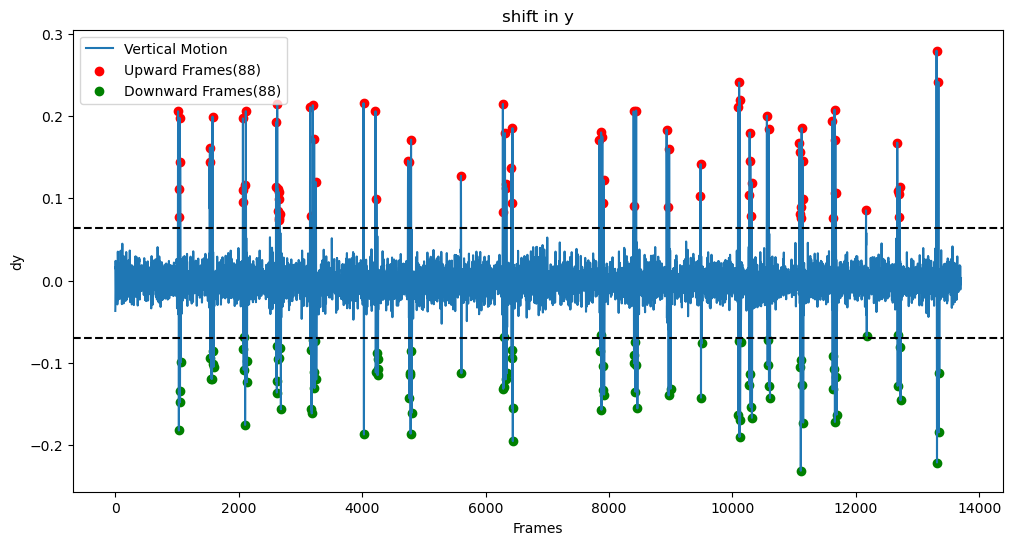

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(-smoothed, label='Vertical Motion')
plt.scatter(upward_peaks, -smoothed[upward_peaks], c='r', label=f'Upward Frames({len(upward_peaks)})')
plt.scatter(downward_peaks, -smoothed[downward_peaks], c='g', label=f'Downward Frames({len(upward_peaks)})')
plt.axhline(upper_threshold, color='k', ls='--')
plt.axhline(lower_threshold, color='k', linestyle='--')

# # Draw cycle markers
# for cycle in cycles:
#     plt.axvspan(cycle[0], cycle[1], alpha=0.2, color='orange')


plt.title("shift in y")
plt.xlabel("Frames")
plt.ylabel("dy")
plt.legend()
# plt.xlim(1000,2000)

# plt.savefig(f"yshift.png", transparent=None,facecolor='white')

In [ ]:
# # Pair upward-downward peaks as cycles
# cycles = []
# for up_idx in upward_peaks:
#     # Find next downward peak after upward peak
#     subsequent_downs = [d for d in downward_peaks if d > up_idx]
#     if subsequent_downs:
#         cycles.append((up_idx, subsequent_downs[0]))

# original_frame_cycles = []
# for cycle in cycles:
#     start = res[cycle[0]]
#     end = res[cycle[1]]
#     original_frame_cycles.append((start, end))

# plot eye angle shadow with motion

In [97]:
import pandas as pd

In [82]:
def get_behavior_timestamps(filename):
    t = np.loadtxt(filename)[:, 1]
    t = (t - t[0]) / 3515839
    return t


def get_tail_angles(df_tail, heading):
    xy = df_tail.values[:, ::2] + df_tail.values[:, 1::2] * 1j
    midline = -np.exp(1j * np.deg2rad(np.asarray(heading)))
    return -np.angle(np.diff(xy, axis=1) / midline[:, None])

In [77]:
def low_pass_filt(x, fs, cutoff, axis=0, order=2):
    from scipy.signal import butter, filtfilt

    b, a = butter(order, cutoff / (fs / 2), btype="low")
    return filtfilt(b, a, x, axis=axis)

In [98]:
def load_data(h5_path, fs):
    from scipy.interpolate import interp1d

    # t = get_behavior_timestamps(Path(h5_path).with_suffix(".txt"))
    t = get_behavior_timestamps(Path('D://testing_data//F6-set001-b-sweep-200-fps.txt'))
    df_eye = pd.read_hdf(h5_path, "eye")
    eye_angles = df_eye[[("left_eye", "angle"), ("right_eye", "angle")]].values
    t_new = np.arange(int(t[-1]) * fs) / fs
    eye_angles = interp1d(t, eye_angles, axis=0, kind="cubic")(t_new)
    df_tail = pd.read_hdf(h5_path, "tail")
    tail_angles = get_tail_angles(df_tail, df_eye["heading"].values)
    tail_angles = interp1d(t, tail_angles, axis=0, kind="cubic")(t_new)

    return t_new, eye_angles, tail_angles

In [102]:
h5_path = "D://testing_data//F6-set001-b-sweep-200-fps.h5"
fs = 200  # target sampling frequency
t, eye_angles, tail_angles = load_data(h5_path, fs)

conv_params = {
    "hw": 100,  # half-width of the step function
    "thr": 0.6,  # threshold for peak height
    "dist": 80,  # distance between events
}
eye_angles_filt = low_pass_filt(eye_angles, fs, 2)

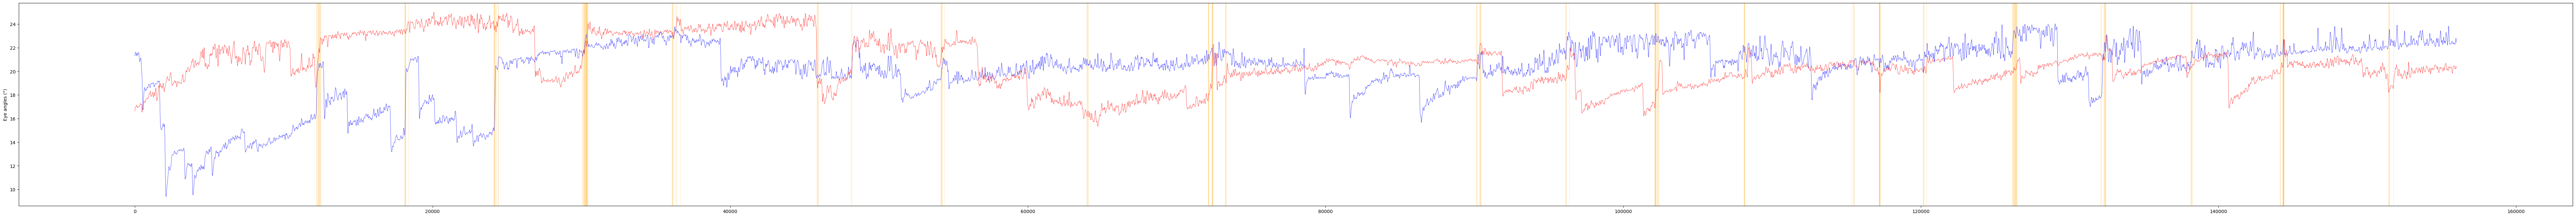

In [120]:
plt.figure(figsize=(100,8))
# fig, ax = plt.subplots()

plt.ylabel("Eye angles (°)")
plt.plot(eye_angles_filt[:, 0], color="b", lw=0.5)
plt.plot(eye_angles_filt[:, 1], color="r", lw=0.5)
for cycle in original_frame_cycles:
    plt.axvspan(cycle[0], cycle[1], alpha=0.2, color='orange')
    
plt.savefig(f"test.png", transparent=None,
        facecolor='white'
       )

In [29]:
from scipy.signal import find_peaks, savgol_filter
def analyze_motion_cycles(video_path, significant_indices, output_plot=True):
    # Load significant frames
    frames = load_significant_frames(video_path, significant_indices)
    
    # Optical Flow Analysis
    vertical_motion = []
    prev_gray = cv.cvtColor(frames[0], cv.COLOR_BGR2GRAY)
    
    for frame in tqdm(frames[1:], desc="Analyzing Motion"):
        curr_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Calculate dense optical flow
        flow = cv.calcOpticalFlowFarneback(
            prev_gray, curr_gray, 
            None, 0.5, 3, 15, 3, 5, 1.2, 0
        )
        
        # Focus on vertical motion (y-axis component)
        vertical_flow = flow[..., 1]
        avg_vertical = np.mean(vertical_flow)
        vertical_motion.append(avg_vertical)
        
        prev_gray = curr_gray

    # Smooth the data
    vertical_motion = np.array(vertical_motion)
    smoothed = savgol_filter(vertical_motion, window_length=11, polyorder=3)
    
    # Detect peaks (downward motion) and valleys (upward motion)
    upward_peaks, _ = find_peaks(-smoothed, prominence=0.5, distance=5)  # Negative for upward
    downward_peaks, _ = find_peaks(smoothed, prominence=0.5, distance=5)  # Positive for downward
    
    # Pair upward-downward peaks as cycles
    cycles = []
    for up_idx in upward_peaks:
        # Find next downward peak after upward peak
        subsequent_downs = [d for d in downward_peaks if d > up_idx]
        if subsequent_downs:
            cycles.append((up_idx, subsequent_downs[0]))
    
    # Visualization
    if output_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(smoothed, label='Vertical Motion')
        plt.scatter(upward_peaks, smoothed[upward_peaks], c='r', label='Upward Peaks')
        plt.scatter(downward_peaks, smoothed[downward_peaks], c='g', label='Downward Peaks')
        
        # Draw cycle markers
        for cycle in cycles:
            plt.axvspan(cycle[0], cycle[1], alpha=0.2, color='orange')
        
        plt.axhline(0, color='k', linestyle='--')
        plt.title("Vertical Motion Analysis")
        plt.xlabel("Frame Index (Significant Frames)")
        plt.ylabel("Vertical Motion (Positive = Downward)")
        plt.legend()
        plt.show()
    
    # Convert cycle indices back to original video frame numbers
    original_frame_cycles = []
    for cycle in cycles:
        start = significant_indices[cycle[0]]
        end = significant_indices[cycle[1]]
        original_frame_cycles.append((start, end))
    
    return {
        'vertical_motion': vertical_motion,
        'smoothed': smoothed,
        'cycles': original_frame_cycles,
        'cycle_count': len(cycles)
    }

Analyzing Motion: 100%|████████████████████████████████████████████████████████| 13700/13700 [00:05<00:00, 2689.25it/s]


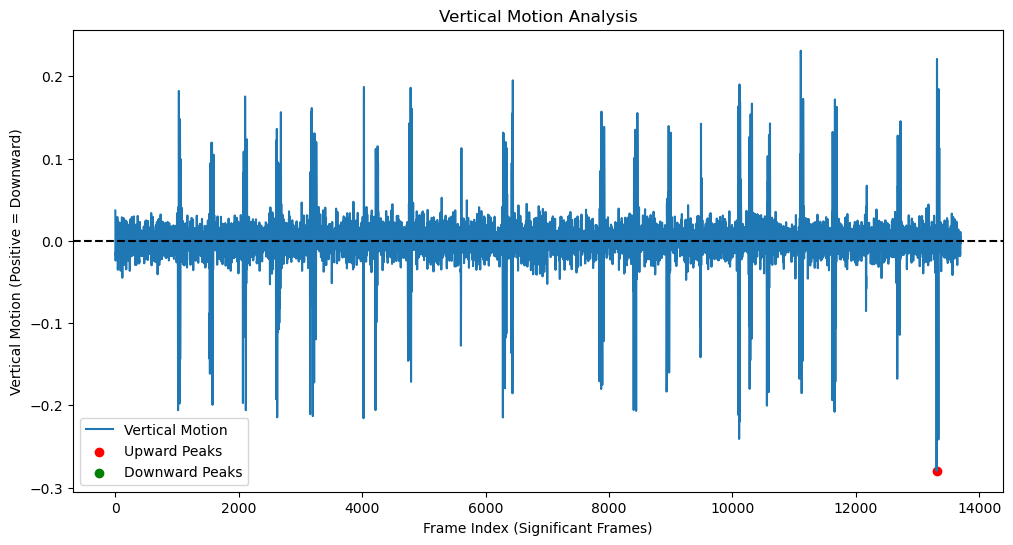

In [33]:
results = analyze_motion_cycles(avi, res)